<a href="https://colab.research.google.com/github/anruki/UFV_Visualizacion/blob/main/EjerciciosClase/Ventas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PREDICCIONES DE VENTAS
---
#### Clase 18/10/2024
#### Asignatura visualización de datos






---



CSV a estudiar:

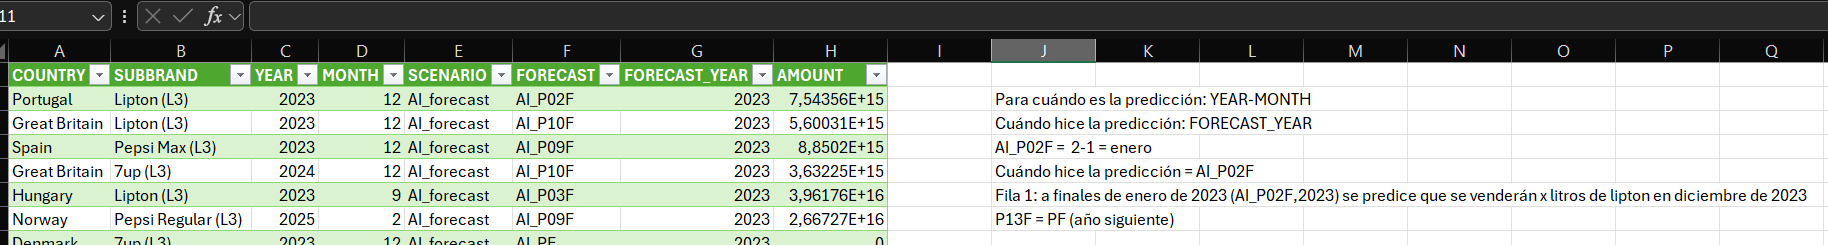

### Importación de librerías y descarga del dataset:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests

Cargamos el DataFrame en `df` con registros de predicciones de ventas:

In [ ]:
# Leer el archivo CSV
df = pd.read_csv('/content/datos_ejercicio_ventas.csv')
df.head(3)

,COUNTRY,SUBBRAND,YEAR,MONTH,SCENARIO,FORECAST,FORECAST_YEAR,AMOUNT
0,Portugal,Lipton (L3),2023,12,AI_forecast,AI_P02F,2023.0,754356.237194
1,Great Britain,Lipton (L3),2023,12,AI_forecast,AI_P10F,2023.0,560030.558029
2,Spain,Pepsi Max (L3),2023,12,AI_forecast,AI_P09F,2023.0,88501.980847


### Primer estudio del dataset

Tiene columnas:

In [ ]:
df.columns

Index(['COUNTRY', 'SUBBRAND', 'YEAR', 'MONTH', 'SCENARIO', 'FORECAST',
       'FORECAST_YEAR', 'AMOUNT'],
      dtype='object')

* `COUNTRY` El país al que se refieren los datos.
* `SUBBRAND` Una subcategoría específica dentro de una marca o línea de productos.
* `YEAR` El año al que se refieren los datos.
* `MONTH` El mes al que se refieren los datos.
* `SCENARIO` El escenario bajo el cual se han generado los datos. Por ejemplo, "AI_forecast" podría indicar que estos son pronósticos generados por inteligencia artificial.
* `FORECAST` Un identificador del pronóstico.
* `FORECAST_YEAR` El año para el cual se está haciendo el pronóstico.
* `AMOUNT` La cantidad de ventas, ingresos u otra métrica que se está midiendo.

`* ChatGPT descripciones`

Y registros:

In [ ]:
df.size

149328



---



Veamos un ejemplo:


En `España`

In [ ]:
spain = df[df['COUNTRY'] == 'Spain']
spain.head()

,COUNTRY,SUBBRAND,YEAR,MONTH,SCENARIO,FORECAST,FORECAST_YEAR,AMOUNT
2,Spain,Pepsi Max (L3),2023,12,AI_forecast,AI_P09F,2023.0,88501.980847
20,Spain,Pepsi Regular (L3),2023,12,AI_forecast,AI_P05F,2023.0,134268.151080
25,Spain,Lipton (L3),2025,3,AI_forecast,AI_P11F,2023.0,9702.217953
62,Spain,7up Free (L3),2024,1,AI_forecast,AI_P04F,2023.0,70144.329753
68,Spain,7up (L3),2024,4,AI_forecast,AI_P02F,2023.0,38882.921227


Se predice sobre la marca `Pepsi Max (L3)`

In [ ]:
pepsi = spain['SUBBRAND'].iloc[0]
pepsi

'Pepsi Max (L3)'

Las siguientes ventas durante cada mes:

In [ ]:
spain_pepsi = spain[spain['SUBBRAND'] == pepsi]
spain_pepsi.head()

,COUNTRY,SUBBRAND,YEAR,MONTH,SCENARIO,FORECAST,FORECAST_YEAR,AMOUNT
2,Spain,Pepsi Max (L3),2023,12,AI_forecast,AI_P09F,2023.0,88501.980847
97,Spain,Pepsi Max (L3),2024,8,AI_forecast,AI_P06F,2023.0,113707.576412
138,Spain,Pepsi Max (L3),2023,10,AI_forecast,AI_P07F,2023.0,141118.720326
161,Spain,Pepsi Max (L3),2024,1,AI_forecast,AI_P07F,2023.0,98341.728528
189,Spain,Pepsi Max (L3),2023,11,AI_forecast,AI_P07F,2023.0,124329.001687


**Columna date**

Incluye `MONTH` y `YEAR`

In [ ]:
# Crear una columna de pandas datetime
df['DATE'] = pd.to_datetime(df.assign(DAY=1)[['YEAR', 'MONTH', 'DAY']])

## Preguntas a responder para entender los datos:
(Antes de responder a la pregunta final)


1.   NºActuals y Forecasts
2.   Horizonte de predicción
Cuando haces una predicción, ej: estás en enero:

  *  predices x ventas para febrero, entonces horizonte de predicción = 1
  *  predices x ventas en febrero, en marzo y, en abril z, entonces horizonte de predicción = 3.

3.  Nº Países y de productos
4.  Histórico de actuals/forecasts
  - Primer dato de ventas real hasta el último
  - Primer dato de veentas forecast hasta el último
5.  Forecasts distintos




---



## 1. Nº Actuals y Forecasts

`AI_forecast` son las predicciones de ventas y `actuals` las ventas reales que se han hecho.

In [ ]:
scen_values = df['SCENARIO'].unique()
print(scen_values)

['AI_forecast' 'actual']


Cuántos valores reales hay, y cuántos predichos

In [ ]:
df['SCENARIO'].value_counts()

,count
SCENARIO,
AI_forecast,17766
actual,900


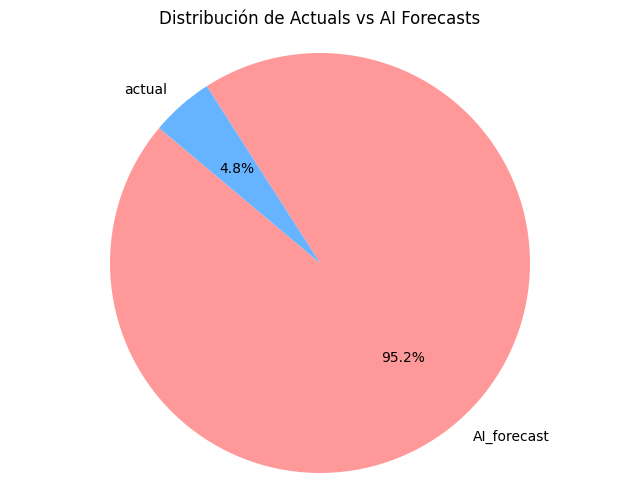

In [ ]:
# Contar el número de entradas para cada escenario
scenario_counts = df['SCENARIO'].value_counts()

# Crear el gráfico de pastel
plt.figure(figsize=(8, 6))
plt.pie(scenario_counts, labels=scenario_counts.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff'])
plt.title('Distribución de Actuals vs AI Forecasts')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Mostrar el gráfico
plt.show()

La mayoría de predicciones son de AI, ya que se hace una predicción en cada mes, hasta que se verifica con el valor real.

## 2. Horizonte de predicción

FORECAST CON FORECAST YEAR - MONTH CON YEAR

In [ ]:
scenarios = df['SCENARIO'].unique()
print(scenarios)

['AI_forecast' 'actual']


Solo queremos las predicciones.

In [ ]:
forecasts = df[df['SCENARIO'] == scenarios[0]]

Se realizan durante los siguientes meses:

`PXF -> X - 1 mes`

In [ ]:
forecasts['FORECAST'].unique()

array(['AI_P02F', 'AI_P10F', 'AI_P09F', 'AI_P03F', 'AI_PF', 'AI_P11F',
       'AI_P06F', 'AI_P05F', 'AI_P07F', 'AI_P12F', 'AI_P08F', 'AI_P04F'],
      dtype=object)

Y solamente durante el año 2023

In [ ]:
forecasts['FORECAST_YEAR'].unique()

array([2023.])

Por otra parte `MONTH` y `YEAR` indica para cuándo es la predicción.

In [ ]:
forecasts['MONTH'].unique()

array([12,  9,  2,  4,  7, 11,  1,  6, 10,  3,  5,  8])

In [ ]:
forecasts['YEAR'].unique()

array([2023, 2024, 2025])

Tomando como ejemplo un solo `FORECAST = AI_P02F` que son las predicciones hechas en enero.

In [ ]:
forecasts[forecasts['FORECAST'] == 'AI_P02F']

,COUNTRY,SUBBRAND,YEAR,MONTH,SCENARIO,FORECAST,FORECAST_YEAR,AMOUNT,DATE
0,Portugal,Lipton (L3),2023,12,AI_forecast,AI_P02F,2023.0,7.543562e+05,2023-12-01
7,Netherlands,Mountain Dew (L3),2024,4,AI_forecast,AI_P02F,2023.0,0.000000e+00,2024-04-01
8,Great Britain,Pepsi Max (L3),2023,9,AI_forecast,AI_P02F,2023.0,1.138557e+07,2023-09-01
28,Italy,7up (L3),2023,6,AI_forecast,AI_P02F,2023.0,1.867226e+04,2023-06-01
30,Denmark,7up Free (L3),2024,5,AI_forecast,AI_P02F,2023.0,1.500290e+04,2024-05-01
...,...,...,...,...,...,...,...,...,...
18613,Netherlands,Pepsi Regular (L3),2023,11,AI_forecast,AI_P02F,2023.0,4.630296e+05,2023-11-01
18623,Netherlands,Pepsi Regular (L3),2023,5,AI_forecast,AI_P02F,2023.0,6.917837e+05,2023-05-01
18635,Hungary,Pepsi Max (L3),2023,8,AI_forecast,AI_P02F,2023.0,5.254369e+05,2023-08-01
18659,Netherlands,Pepsi Regular (L3),2024,7,AI_forecast,AI_P02F,2023.0,4.683627e+05,2024-07-01




---



## 3. Nº de países y de productos

* Países:

In [ ]:
paises = df['COUNTRY'].unique()
print(paises)

['Portugal' 'Great Britain' 'Spain' 'Hungary' 'Norway' 'Denmark'
 'Netherlands' 'Italy' 'Czech']


En total hay `9` países

In [ ]:
paises.size

9

Cada país tiene los siguientes registros en total:

In [ ]:
df['COUNTRY'].value_counts()

,count
COUNTRY,
Great Britain,4008
Netherlands,2476
Hungary,2384
Denmark,2294
Spain,2152
Norway,2062
Czech,1403
Portugal,1179
Italy,708


Destacamos que la mayoría de registros de ventas se producen en Gran Bretaña.

* Productos

In [ ]:
productos = df['SUBBRAND'].unique()
print(productos)

['Lipton (L3)' 'Pepsi Max (L3)' '7up (L3)' 'Pepsi Regular (L3)'
 'Mountain Dew (L3)' '7up Free (L3)']


En total hay `6` productos

In [ ]:
productos.size

6

Cada producto tiene los siguientes registros en total:

In [ ]:
df['SUBBRAND'].value_counts()

,count
SUBBRAND,
Pepsi Max (L3),5598
Pepsi Regular (L3),3636
7up (L3),2694
Lipton (L3),2693
7up Free (L3),2343
Mountain Dew (L3),1702


## 4.  Histórico de actuals/forecasts
  - Primer dato de ventas real hasta el último
  - Primer dato de veentas forecast hasta el último



---
IMPORTANTE: he usado 'date' en vez de forecast, 'date' muestra para cuando son las predicciones.


---



In [ ]:
scenarios = df['SCENARIO'].unique()
print(scenarios)

['AI_forecast' 'actual']


* Datos reales de ventas

In [ ]:
actuals = df[df['SCENARIO'] == scenarios[1]]
actuals.head()

,COUNTRY,SUBBRAND,YEAR,MONTH,SCENARIO,FORECAST,FORECAST_YEAR,AMOUNT,DATE
277,Portugal,Pepsi Max (L3),2023,10,actual,NaN,NaN,1.885949e+05,2023-10-01
278,Portugal,7up (L3),2023,3,actual,NaN,NaN,2.934971e+05,2023-03-01
279,Portugal,7up (L3),2023,10,actual,NaN,NaN,3.484466e+05,2023-10-01
280,Great Britain,7up Free (L3),2023,10,actual,NaN,NaN,1.172553e+06,2023-10-01
281,Norway,Pepsi Regular (L3),2023,10,actual,NaN,NaN,3.784859e+04,2023-10-01


* Primer dato real de ventas

In [ ]:
# Ordenamos el DataFrame por la columna de fechas y seleccionamos el primer registro
actual_first = actuals.sort_values('DATE').iloc[0]
actual_first

,11275
COUNTRY,Norway
SUBBRAND,Pepsi Regular (L3)
YEAR,2023
MONTH,1
SCENARIO,actual
FORECAST,NaN
FORECAST_YEAR,NaN
AMOUNT,34297.395969
DATE,2023-01-01 00:00:00


¿Cuántos registros de ventas se hicieron en esa fecha?

In [ ]:
actuals[actuals['DATE'] == actual_first['DATE']].size

396

* Último dato real de ventas

In [ ]:
# Ordenamos el DataFrame por la columna de fechas y seleccionamos el primer registro
actual_last = actuals.sort_values('DATE').iloc[-1]
actual_last

,14323
COUNTRY,Great Britain
SUBBRAND,Pepsi Max (L3)
YEAR,2024
MONTH,8
SCENARIO,actual
FORECAST,NaN
FORECAST_YEAR,NaN
AMOUNT,14138482.706649
DATE,2024-08-01 00:00:00


De manera visual, podemos graficar las ventas de cada producto a lo largo del tiempo.

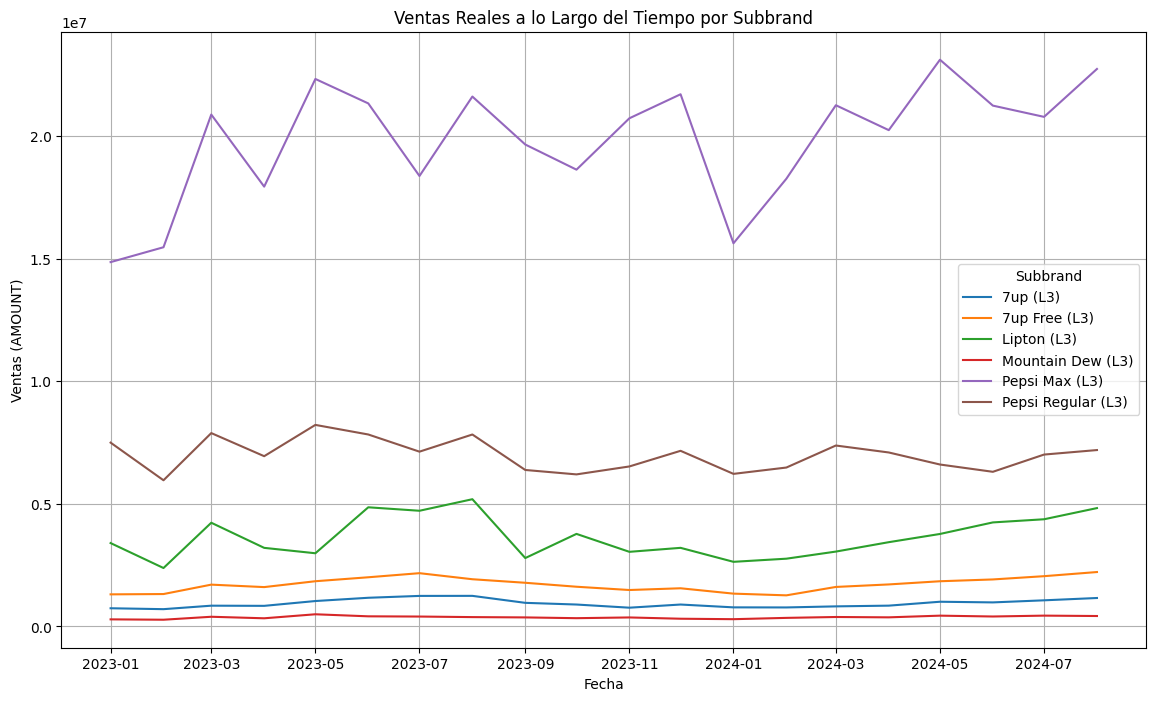

In [ ]:
# Agrupamos los datos por fecha y subbrand y sumamos los valores de ventas (AMOUNT) para cada combinación
actuals_grouped = actuals.groupby(['DATE', 'SUBBRAND'])['AMOUNT'].sum().reset_index()

# Configuramos la gráfica
plt.figure(figsize=(14, 8))

# Graficamos una línea para cada subbrand
for subbrand in actuals_grouped['SUBBRAND'].unique():
    subbrand_data = actuals_grouped[actuals_grouped['SUBBRAND'] == subbrand]
    plt.plot(subbrand_data['DATE'], subbrand_data['AMOUNT'], label=subbrand)

# Añadimos etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Ventas (AMOUNT)')
plt.title('Ventas Reales a lo Largo del Tiempo por Subbrand')
plt.legend(title='Subbrand')
plt.grid(True)

# Mostramos la gráfica
plt.show()

Además podríamos simplificar esto agrupando los productos que son de la misma marca como `7up (L3)` y `7up Free (L3)`

In [ ]:
df['SUBBRAND'].unique()

array(['Lipton (L3)', 'Pepsi Max (L3)', '7up (L3)', 'Pepsi Regular (L3)',
       'Mountain Dew (L3)', '7up Free (L3)'], dtype=object)

<ipython-input-30-5c1418a616c6>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actuals['SUBBRAND_GROUPED'] = actuals['SUBBRAND'].map(subbrand_mapping)


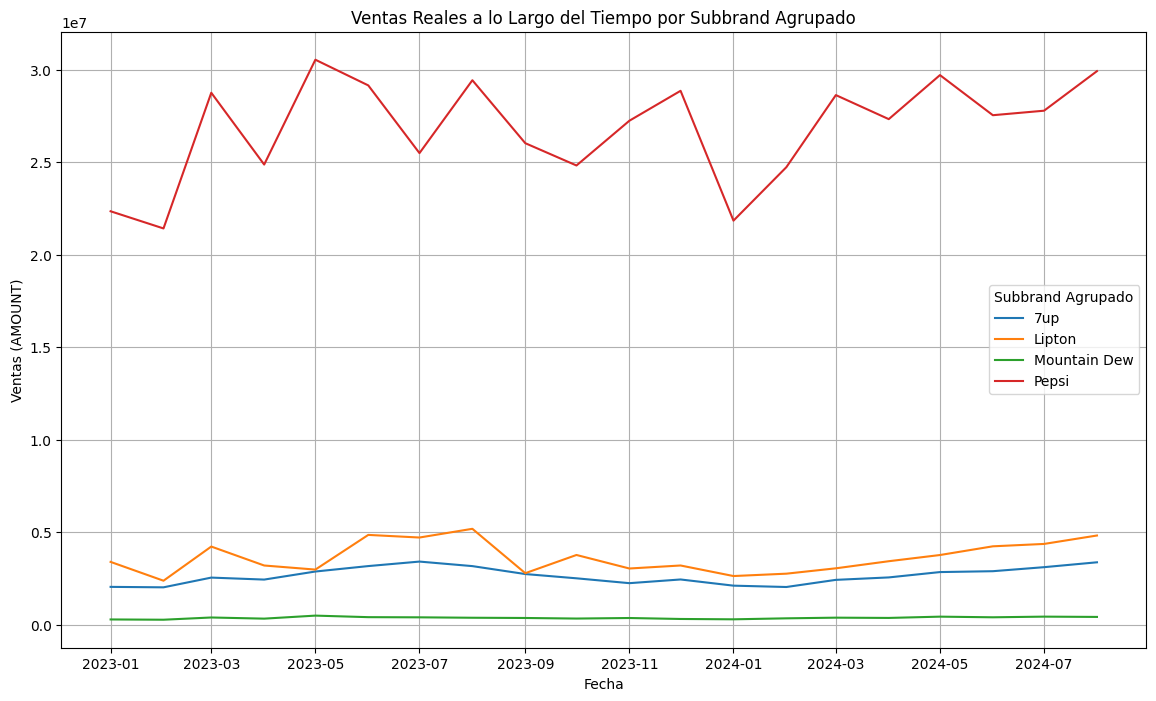

In [ ]:

# Creamos un diccionario para agrupar las submarcas
subbrand_mapping = {
    'Pepsi Max (L3)': 'Pepsi',
    'Pepsi Regular (L3)': 'Pepsi',
    '7up (L3)': '7up',
    '7up Free (L3)': '7up',
    'Lipton (L3)': 'Lipton',
    'Mountain Dew (L3)': 'Mountain Dew'
}

# Creamos una nueva columna de SUBBRAND_GROUPED mapeando las submarcas
actuals['SUBBRAND_GROUPED'] = actuals['SUBBRAND'].map(subbrand_mapping)

# Agrupamos los datos por fecha y la nueva columna SUBBRAND_GROUPED y sumamos los valores de ventas (AMOUNT)
actuals_grouped = actuals.groupby(['DATE', 'SUBBRAND_GROUPED'])['AMOUNT'].sum().reset_index()

# Configuramos la gráfica
plt.figure(figsize=(14, 8))

# Graficamos una línea para cada subbrand agrupado
for subbrand in actuals_grouped['SUBBRAND_GROUPED'].unique():
    subbrand_data = actuals_grouped[actuals_grouped['SUBBRAND_GROUPED'] == subbrand]
    plt.plot(subbrand_data['DATE'], subbrand_data['AMOUNT'], label=subbrand)

# Añadimos etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Ventas (AMOUNT)')
plt.title('Ventas Reales a lo Largo del Tiempo por Subbrand Agrupado')
plt.legend(title='Subbrand Agrupado')
plt.grid(True)

# Mostramos la gráfica
plt.show()

* Datos predichos de ventas

In [ ]:
forecasts = df[df['SCENARIO'] == scenarios[0]]
forecasts.head()

,COUNTRY,SUBBRAND,YEAR,MONTH,SCENARIO,FORECAST,FORECAST_YEAR,AMOUNT,DATE
0,Portugal,Lipton (L3),2023,12,AI_forecast,AI_P02F,2023.0,754356.237194,2023-12-01
1,Great Britain,Lipton (L3),2023,12,AI_forecast,AI_P10F,2023.0,560030.558029,2023-12-01
2,Spain,Pepsi Max (L3),2023,12,AI_forecast,AI_P09F,2023.0,88501.980847,2023-12-01
3,Great Britain,7up (L3),2024,12,AI_forecast,AI_P10F,2023.0,363224.511516,2024-12-01
4,Hungary,Lipton (L3),2023,9,AI_forecast,AI_P03F,2023.0,396176.120491,2023-09-01


Nota: `DATE` indica para cuándo es la predicción.

* Primer dato predicho de ventas

In [ ]:
# Ordenamos el DataFrame por la columna de fechas y seleccionamos el primer registro
forecast_first = forecasts.sort_values('DATE').iloc[0]
forecast_first

,3628
COUNTRY,Portugal
SUBBRAND,7up (L3)
YEAR,2023
MONTH,1
SCENARIO,AI_forecast
FORECAST,AI_PF
FORECAST_YEAR,2023.0
AMOUNT,289120.980222
DATE,2023-01-01 00:00:00


¿Cuántas predicciones se hicieron para esa fecha?

In [ ]:
forecasts[forecasts['DATE'] == forecast_first['DATE']].size

639

* Último dato predicho de ventas

In [ ]:
# Ordenamos el DataFrame por la columna de fechas y seleccionamos el primer registro
forecast_last = forecasts.sort_values('DATE').iloc[-1]
forecast_last

,15769
COUNTRY,Netherlands
SUBBRAND,Pepsi Max (L3)
YEAR,2025
MONTH,5
SCENARIO,AI_forecast
FORECAST,AI_P12F
FORECAST_YEAR,2023.0
AMOUNT,1024964.029014
DATE,2025-05-01 00:00:00


¿Cuántas predicciones se hicieron para esa fecha?

In [ ]:
forecasts[forecasts['DATE'] == forecast_last['DATE']].size

846

Representamos los resultados obtenidos:

<ipython-input-36-b8f0ae39cf9a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecasts['SUBBRAND_GROUPED'] = forecasts['SUBBRAND'].map(subbrand_mapping)


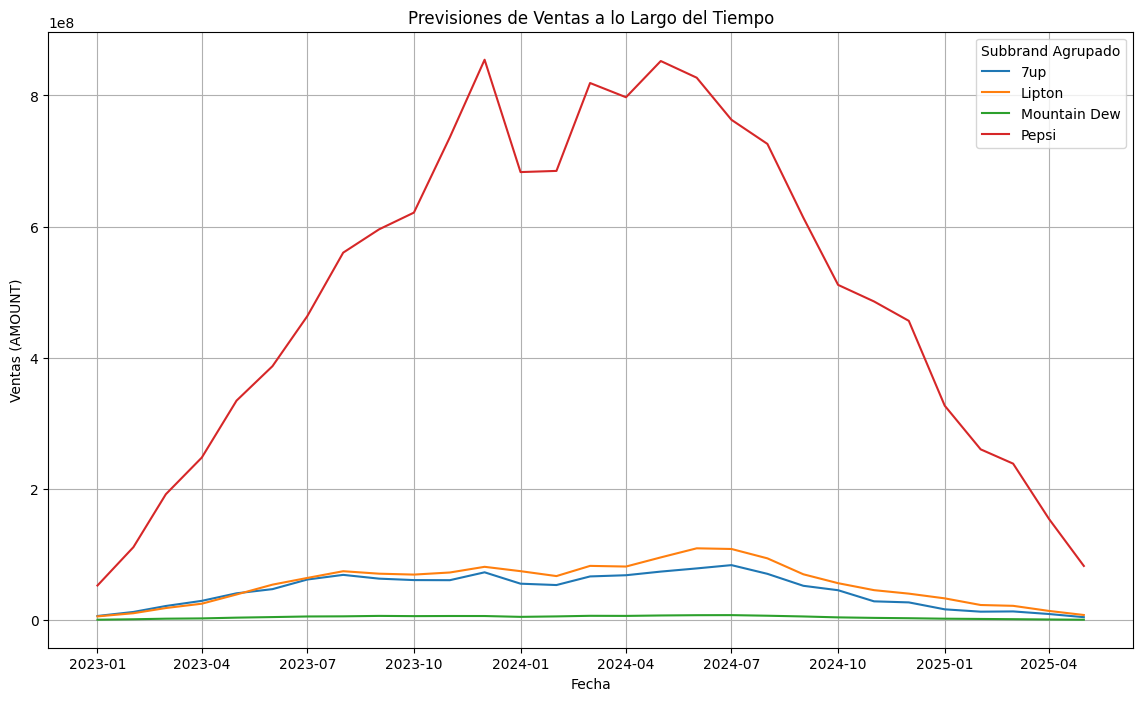

In [ ]:

# Creamos un diccionario para agrupar las submarcas
subbrand_mapping = {
    'Pepsi Max (L3)': 'Pepsi',
    'Pepsi Regular (L3)': 'Pepsi',
    '7up (L3)': '7up',
    '7up Free (L3)': '7up',
    'Lipton (L3)': 'Lipton',
    'Mountain Dew (L3)': 'Mountain Dew'
}

# Creamos una nueva columna de SUBBRAND_GROUPED mapeando las submarcas
forecasts['SUBBRAND_GROUPED'] = forecasts['SUBBRAND'].map(subbrand_mapping)

# Agrupamos los datos por fecha y la nueva columna SUBBRAND_GROUPED y sumamos los valores de ventas (AMOUNT)
forecasts_grouped = forecasts.groupby(['DATE', 'SUBBRAND_GROUPED'])['AMOUNT'].sum().reset_index()

# Configuramos la gráfica
plt.figure(figsize=(14, 8))

# Graficamos una línea para cada subbrand agrupado
for subbrand in forecasts_grouped['SUBBRAND_GROUPED'].unique():
    subbrand_data = forecasts_grouped[forecasts_grouped['SUBBRAND_GROUPED'] == subbrand]
    plt.plot(subbrand_data['DATE'], subbrand_data['AMOUNT'], label=subbrand)

# Añadimos etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Previsiones Ventas (AMOUNT)')
plt.title('Previsiones de Ventas a lo Largo del Tiempo')
plt.legend(title='Subbrand Agrupado')
plt.grid(True)

# Mostramos la gráfica
plt.show()

Para saber en qué momento se hizo la primera predicción hay que usar `FORECAST`

Parece que todas las predicciones se hicieron durante el 2023.

In [ ]:
forecasts['FORECAST_YEAR'].unique()

array([2023.])

Y para ver en qué mes:

In [ ]:
forecasts['FORECAST'].unique()

array(['AI_P02F', 'AI_P10F', 'AI_P09F', 'AI_P03F', 'AI_PF', 'AI_P11F',
       'AI_P06F', 'AI_P05F', 'AI_P07F', 'AI_P12F', 'AI_P08F', 'AI_P04F'],
      dtype=object)

## Preguntas a responder
(Con gráficas)

1. Como se distribuyen las ventas realizadas en:
  * Cada país
  * Cada mes y año
  * Cada marca
2. Cual es la tendencia y estacionalidad de:
  * Todas las ventas del país con menos ventas
  * La marca con más ventas
3. Cuales son las predicciones hechas en España y como de
buenas son

# 1. Cómo se distribuyen las ventas realizadas en ...

## Cada País:

Recordamos que los países del dataFrame son:

In [ ]:
df